In [1]:
# Importing necessary libraries and checking compatible versions as well
import sklearn
import imblearn

print("Scikit-learn version:", sklearn.__version__)
print("Imbalanced-learn version:", imblearn.__version__)

Scikit-learn version: 1.6.0
Imbalanced-learn version: 0.12.4


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load a sample of the dataset
file_path = "Fraud.csv" 
df = pd.read_csv(file_path)

## Pre-processing & Visualization

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
# 1. Handling Missing Values
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


No missing value in the dataset to be handled.

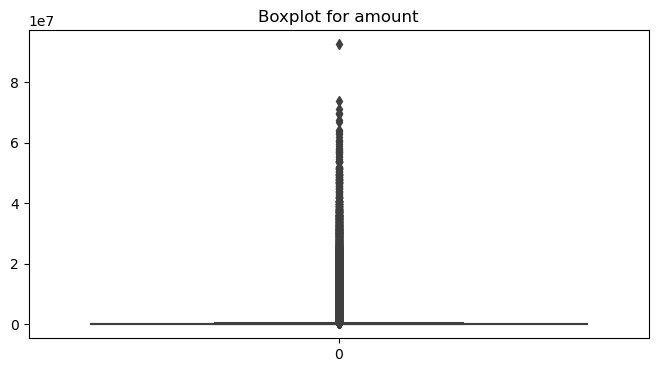

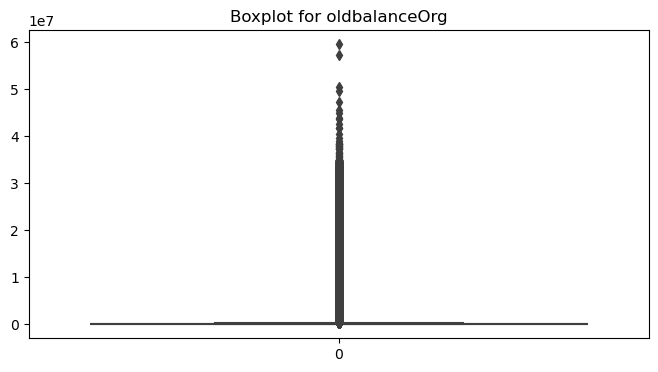

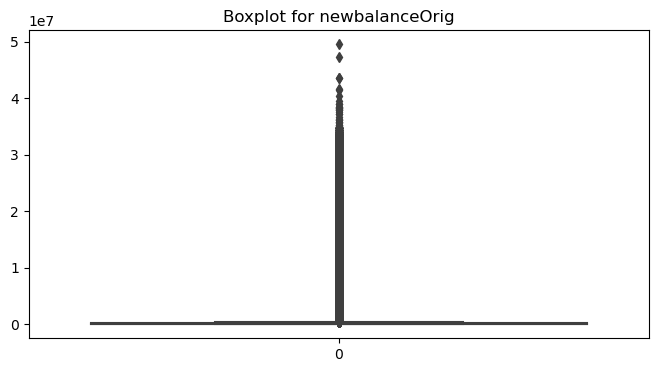

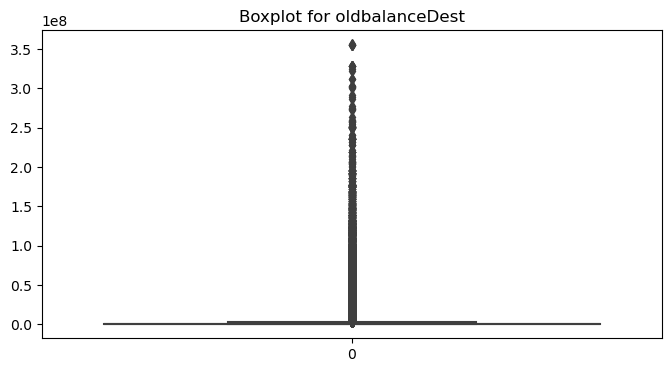

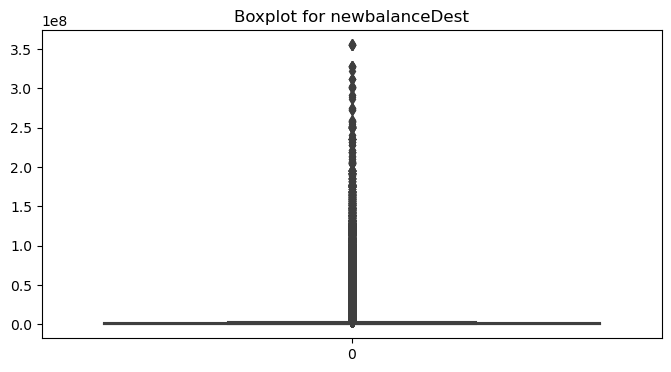

In [6]:
# 2. Outlier Detection (Boxplots for Visualization)
numeric_columns = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

for col in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(df[col])
    plt.title(f"Boxplot for {col}")
    plt.show()

In [7]:
# Optionally, handle outliers (e.g., clipping or removing extreme values)
# for col in numeric_columns:
#     Q1 = df[col].quantile(0.25)
#     Q3 = df[col].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# print("Dataset shape after outlier removal:", df.shape)

# Removes a lot of data in this case so let it be 

Percentage of Legit transactions: 99.8709 %
Percentage of Fraud transactions: 0.1291 %


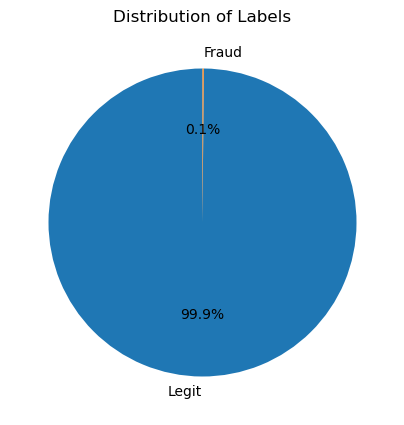

In [8]:
# Visualization of fraud transactions

legit = len(df[df.isFraud == 0])
fraud = len(df[df.isFraud == 1])
legit_percent = (legit / (fraud + legit)) * 100
fraud_percent = (fraud / (fraud + legit)) * 100


print("Percentage of Legit transactions: {:.4f} %".format(legit_percent))
print("Percentage of Fraud transactions: {:.4f} %".format(fraud_percent))

labels = ["Legit", "Fraud"]
count_classes = df['isFraud'].value_counts()

plt.figure(figsize=(5,5))
plt.pie(count_classes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Labels")
plt.show()

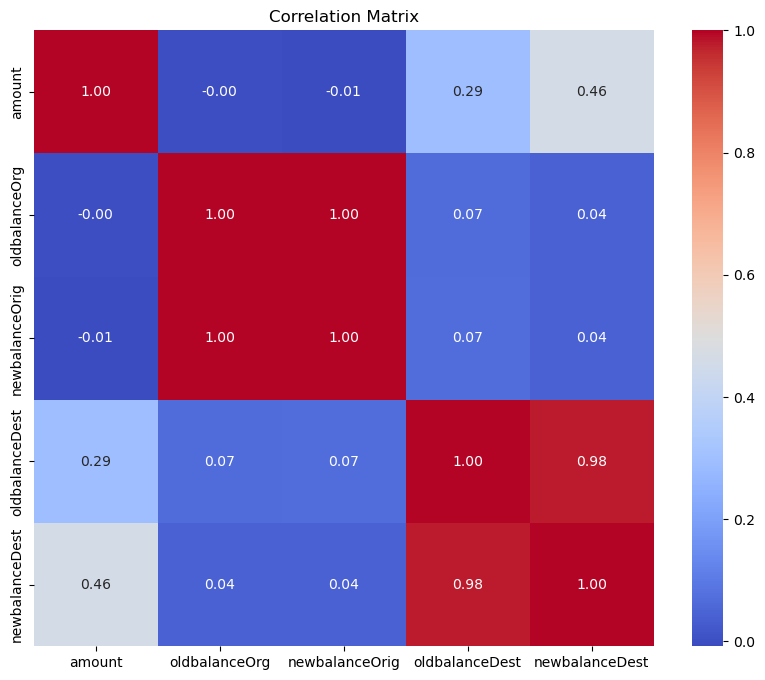

Highly Correlated Pairs: [('oldbalanceOrg', 'newbalanceOrig', 0.9988027631723787), ('newbalanceOrig', 'oldbalanceOrg', 0.9988027631723787), ('oldbalanceDest', 'newbalanceDest', 0.9765685054474923), ('newbalanceDest', 'oldbalanceDest', 0.9765685054474923)]


In [9]:
# 3. Multi-Collinearity (Correlation Heatmap)
plt.figure(figsize=(10, 8))
correlation_matrix = df[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Identifying highly correlated variables
threshold = 0.8
high_corr_pairs = [
    (i, j, correlation_matrix.loc[i, j])
    for i in correlation_matrix.columns
    for j in correlation_matrix.columns
    if i != j and abs(correlation_matrix.loc[i, j]) > threshold
]
print("Highly Correlated Pairs:", high_corr_pairs)

## Data Manupulation

In [10]:
new_df=df.copy()
new_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [11]:
# 4. Lable Encoding
objList = new_df.select_dtypes(include = "object").columns
print (objList)

#Label Encoding for object to numeric conversion
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feat in objList:
    new_df[feat] = le.fit_transform(new_df[feat].astype(str))

print (new_df.info())

Index(['type', 'nameOrig', 'nameDest'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int32  
 2   amount          float64
 3   nameOrig        int32  
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        int32  
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int32(3), int64(3)
memory usage: 461.2 MB
None


In [12]:
# 5. Import library for VIF (VARIANCE INFLATION FACTOR)

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(df):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return(vif)

calc_vif(new_df)

,variables,VIF
0,step,2.791610
1,type,4.467405
2,amount,4.149312
3,nameOrig,2.764234
4,oldbalanceOrg,576.803777
5,newbalanceOrig,582.709128
6,nameDest,3.300975
7,oldbalanceDest,73.349937
8,newbalanceDest,85.005614
9,isFraud,1.195305


If the VIF is greater than 3, the uncertainty in the estimated coefficients makes the model useless.
So to adjust these let's make some meaningful changes and remove few variables.

In [13]:
# To reduce the redundancy
new_df['Actual_amount_orig'] = new_df.apply(lambda x: x['oldbalanceOrg'] - x['newbalanceOrig'],axis=1)
new_df['Actual_amount_dest'] = new_df.apply(lambda x: x['oldbalanceDest'] - x['newbalanceDest'],axis=1)
new_df['TransactionPath'] = new_df.apply(lambda x: x['nameOrig'] + x['nameDest'],axis=1)

# Dropping columns
new_df = new_df.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','step','nameOrig','nameDest'],axis=1)

calc_vif(new_df)

,variables,VIF
0,type,2.687803
1,amount,3.818902
2,isFraud,1.184479
3,isFlaggedFraud,1.002546
4,Actual_amount_orig,1.307910
5,Actual_amount_dest,3.754335
6,TransactionPath,2.677167


<Axes: >

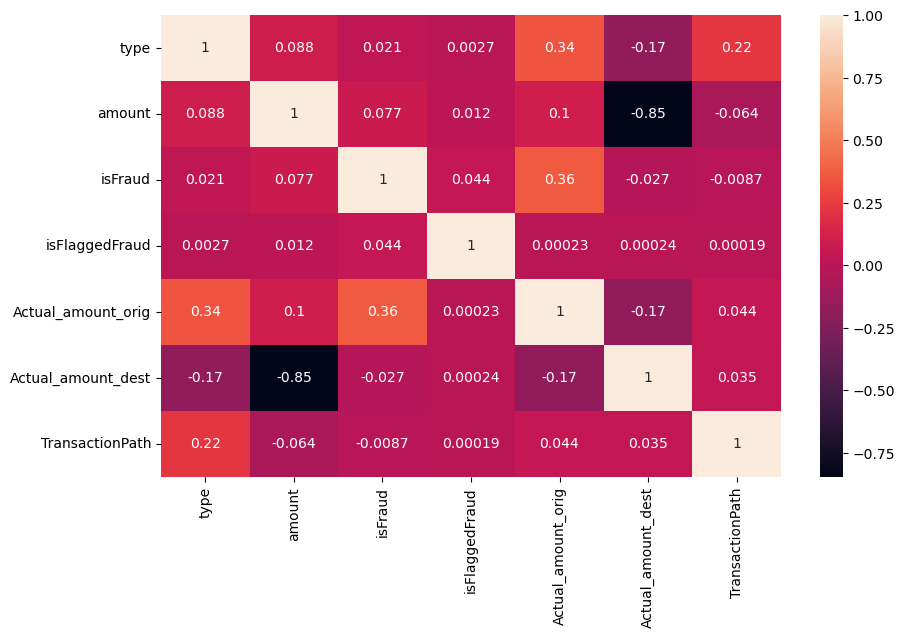

In [14]:
corr=new_df.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True)

## Model Building and Development

In [15]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [16]:
# 1. Feature Selection and Target
# Drop non-numeric or non-essential columns for the model
features = ['type', 'amount', 'Actual_amount_orig', 'Actual_amount_dest', 'isFlaggedFraud','TransactionPath']
target = 'isFraud'

X = new_df[features]
y = new_df[target]

In [17]:
# 2. Handle Class Imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print("Class Distribution After SMOTE:", y_resampled.value_counts())

C:\Users\das10\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\das10\anaconda3\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Class Distribution After SMOTE: 0    6354407
1    6354407
Name: isFraud, dtype: int64


In [18]:
# 3. Split into Train, Validation, and Test Sets
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 4. Normalize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 5. Model Development with Hyperparameter Tuning
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

In [ ]:
# 6. Evaluate Model on Validation Set
y_val_pred = best_model.predict(X_val_scaled)
print("\nValidation Set Performance:")
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
print("AUC-ROC Score:", roc_auc_score(y_val, best_model.predict_proba(X_val_scaled)[:, 1]))

# 7. Test the Model on the Test Set
y_test_pred = best_model.predict(X_test_scaled)
print("\nTest Set Performance:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, best_model.predict_proba(X_test_scaled)[:, 1]))

## Q&A

1) How did you select variables to be included in the model?
Using the VIF values and correlation heatmap. Drop the attributes which are least corelated to the isFraud attribute.

2) What are the key factors that predict fraudulent customer?
Old vs. New Balance: Significant changes in account balances.
Unusual high amount trasactions can be fraud.
Payment type - Transfer

3) Do these factors make sense? If yes, How? If not, How not?
Significant changes in account balances (either large increases or decreases) can be indicative of fraud. For instance, if an account suddenly has a much lower balance after a transaction, it might signal a large unauthorized withdrawal.
Fraudulent transactions often involve large amounts of money to maximize the impact before the fraud is detected.
Certain types of transactions, like transfers, are more susceptible to fraud compared to others like regular bill payments or purchases.

4) What kind of prevention should be adopted while company update its infrastructure?
Infrastructure Updates:
    - Implement real-time fraud detection systems.
    - Establish transaction limits based on customer profiles.
    - Flag suspicious transactions for manual review.

5) Assuming these actions have been implemented, how would you determine if they work?
Monitor key metrics post-implementation:
    - Reduction in fraudulent transactions.
    - Number of flagged transactions resolved correctly.
Compare the incidence of fraud before and after implementation using hypothesis testing.